In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
tf.config.run_functions_eagerly(True)


from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix


In [2]:
# Dataset path (already extracted to this path in your setup)
data_dir = r"C:\Users\Madhumitha\Downloads\chest_xray_56\chest_xray"
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")
test_dir = os.path.join(data_dir, "test")

# Image dimensions and batch size
img_size = (150, 150)
batch_size = 32


In [3]:
# Data Augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    horizontal_flip=True
)

# Validation and testing (no augmentation)
test_val_datagen = ImageDataGenerator(rescale=1./255)

# Load train, val, and test sets
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)

val_generator = test_val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_val_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=1,  # Use batch_size=1 for per-image evaluation
    class_mode='binary',
    shuffle=False
)


Found 100 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 101 images belonging to 2 classes.


In [4]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(*img_size, 3)),
    MaxPooling2D(2, 2),
    BatchNormalization(),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    BatchNormalization(),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    BatchNormalization(),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    BatchNormalization(),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])


C:\Users\Madhumitha\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [5]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)


In [6]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Assuming your labels are from train_generator
labels = train_generator.classes  # Get labels from ImageDataGenerator

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)
class_weights = dict(enumerate(class_weights))


# Train the model using class weights
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    class_weight=class_weights  # 👈 this is the fix!
)


C:\Users\Madhumitha\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


C:\Users\Madhumitha\AppData\Local\Programs\Python\Python312\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 690ms/step - accuracy: 0.5297 - loss: 1.1820 - val_accuracy: 0.5000 - val_loss: 0.6941
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 667ms/step - accuracy: 0.8152 - loss: 0.3944 - val_accuracy: 0.5625 - val_loss: 0.6871
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 871ms/step - accuracy: 0.8313 - loss: 0.8936 - val_accuracy: 0.5000 - val_loss: 0.6923
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 612ms/step - accuracy: 0.7815 - loss: 0.5281 - val_accuracy: 0.5000 - val_loss: 0.7112
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 633ms/step - accuracy: 0.8852 - loss: 0.2024 - val_accuracy: 0.5000 - val_loss: 0.7381
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 676ms/step - accuracy: 0.8820 - loss: 0.2725 - val_accuracy: 0.5000 - val_loss: 0.7699
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 718ms/step - accuracy: 0.8299 - loss: 0.3701 - val_accuracy: 0.5000 - val_loss: 0.7947
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 663ms/step - accuracy: 0.9323 - loss: 0.1929 - val_accuracy: 0.5000 - val_loss: 0.8190
Epo

In [7]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    zoom_range=0.2,
    shear_range=0.2,    horizontal_flip=True,
    fill_mode='nearest'
)


In [8]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


In [9]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(*img_size, 3))
base_model.trainable = False  # Freeze base

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])


C:\Users\Madhumitha\AppData\Local\Temp\ipykernel_280412\1325895590.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(*img_size, 3))


In [10]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)


In [11]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)


In [12]:
loss, accuracy = model.evaluate(test_generator)
print(f"✅ Test Accuracy: {accuracy:.4f}")


101/101 ━━━━━━━━━━━━━━━━━━━━ 16s 155ms/step - accuracy: 0.7056 - loss: 0.5664
✅ Test Accuracy: 0.4455


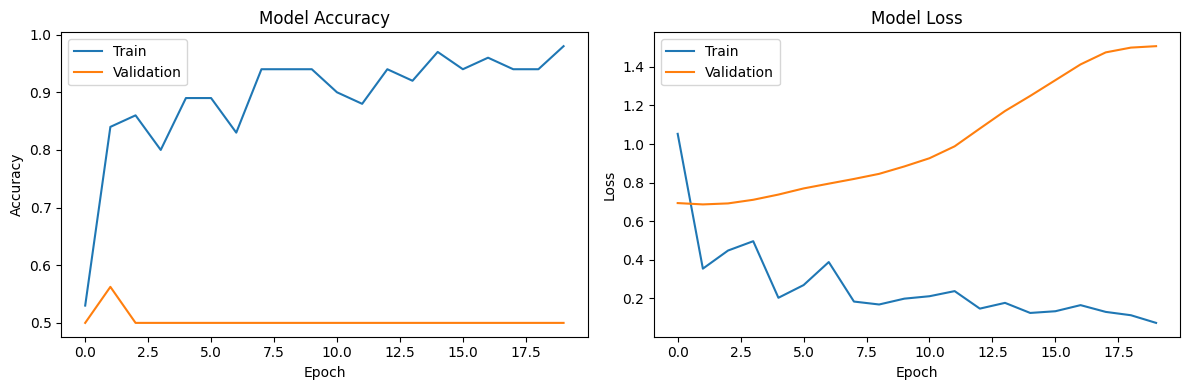

In [13]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [14]:
model.save("pneumonia_cnn_model.h5")


In [21]:
from tkinter import Tk
from tkinter.filedialog import askopenfilename

# Open a file dialog to select an image
Tk().withdraw()  # Prevents extra GUI window

file_path = askopenfilename(title='Select Chest X-Ray Image')
print("📂 Selected image:", file_path)


📂 Selected image: C:/Users/Madhumitha/Downloads/chest_xray_56/chest_xray/train/NORMAL/IM-0160-0001.jpeg


In [22]:
from tensorflow.keras.preprocessing import image

def predict_image(file_path):
    img = image.load_img(file_path, target_size=(150, 150))  # Resize to model input size
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)

    if prediction.shape[1] == 1:
        # Binary classification (sigmoid)
        label = 'PNEUMONIA' if prediction[0][0] > 0.5 else 'NORMAL'
        confidence = prediction[0][0] if prediction[0][0] > 0.5 else 1 - prediction[0][0]
    else:
        # Multi-class (softmax)
        class_labels = ['NORMAL', 'PNEUMONIA']
        label = class_labels[np.argmax(prediction)]
        confidence = np.max(prediction)

    print(f"🩺 Predicted: {label} (Confidence: {confidence:.2f})")

    # Display the image
    plt.imshow(img)
    plt.title(f'Prediction: {label} ({confidence:.2f})')
    plt.axis('off')
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
🩺 Predicted: NORMAL (Confidence: 0.64)


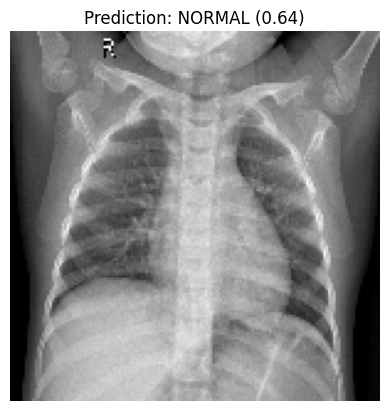

In [23]:
predict_image(file_path)


In [18]:
pip install streamlit


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: C:\Users\Madhumitha\AppData\Local\Programs\Python\Python312\python.exe -m pip install --upgrade pip


In [19]:
# Save the model
model.save("pneumonia_model.h5")
print("✅ Model saved as 'pneumonia_model.h5'")


✅ Model saved as 'pneumonia_model.h5'


In [20]:
streamlit run app.py


SyntaxError: invalid syntax (507122745.py, line 1)

In [ ]:
import streamlit as st
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
from PIL import Image

# Load your trained model
model = load_model("pneumonia_model.h5")  # Make sure to give correct path

# Set title
st.title("🩺 Chest X-Ray Pneumonia Detection")
st.markdown("Upload a chest X-ray image, and the model will predict whether it's NORMAL or PNEUMONIA.")

# File uploader
uploaded_file = st.file_uploader("Choose a chest X-ray image...", type=["jpg", "jpeg", "png"])

if uploaded_file is not None:
    img = Image.open(uploaded_file)
    st.image(img, caption='Uploaded X-ray', use_column_width=True)

    # Preprocess
    img = img.resize((150, 150))  # Match model input
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Predict
    prediction = model.predict(img_array)

    if prediction[0][0] > 0.5:
        st.error("❌ Prediction: PNEUMONIA")
    else:
        st.success("✅ Prediction: NORMAL")
